# Model training

In [188]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRFRegressor
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score


from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [227]:
df_final = pd.read_csv("RestWaterRodent_data.csv.zip")

Index(['Unnamed: 0', 'CAMIS', 'GRADE DATE', 'ZIPCODE', 'CUISINE DESCRIPTION',
       'VIOLATION CODE', 'GRADE', 'BBL', 'ClosestWorkingTankDis',
       'ClosestBadTankDis', 'BORO_Bronx', 'BORO_Brooklyn', 'BORO_Manhattan',
       'BORO_Queens', 'BORO_Staten Island', 'CRITICAL FLAG_Not Critical',
       'ClosestWorkingTankDate', 'ClosestBadTankDate', 'INSPECTION_DATE',
       'RESULT'],
      dtype='object')

In [219]:
# Keep columns not for training as metadata
print(df_final.shape)
# meta_final = df_final[['CAMIS', 'GRADE DATE', 'VIOLATION CODE','ClosestWorkingTankDate', 'ClosestBadTankDate', 'PREV_GRADE DATE', 'INSPECTION_DATE']]

# data for model training
data = df_final[["ZIPCODE", 
                 "CUISINE DESCRIPTION", 
                 "ClosestWorkingTankDis", 
                 "ClosestBadTankDis", 
                 "BORO_Bronx",
                 "BORO_Brooklyn",
                 "BORO_Manhattan",
                 "BORO_Queens",
                 "BORO_Staten Island",
                 "RESULT",
                 "GRADE"
                 ]]
data.head()

(56449, 20)
Index(['Unnamed: 0', 'CAMIS', 'GRADE DATE', 'ZIPCODE', 'CUISINE DESCRIPTION',
       'VIOLATION CODE', 'GRADE', 'BBL', 'ClosestWorkingTankDis',
       'ClosestBadTankDis', 'BORO_Bronx', 'BORO_Brooklyn', 'BORO_Manhattan',
       'BORO_Queens', 'BORO_Staten Island', 'CRITICAL FLAG_Not Critical',
       'ClosestWorkingTankDate', 'ClosestBadTankDate', 'INSPECTION_DATE',
       'RESULT'],
      dtype='object')


,ZIPCODE,CUISINE DESCRIPTION,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,RESULT,GRADE
0,2.876777,2.778831,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,NaN,3.0
1,2.876777,2.778831,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,NaN,3.0
2,2.876777,2.778831,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,NaN,3.0
3,2.801389,2.913240,0.226460,4.392523,0.0,1.0,0.0,0.0,0.0,0.0,3.0
4,2.801389,2.913240,0.226460,4.392523,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [222]:
# Train test split
data.loc[data['GRADE'] == 1, 'GRADE'] = 1
data.loc[data['GRADE'] == 2, "GRADE"] = 1
data.loc[data['GRADE'] == 3, "GRADE"] = 0

dev, test = train_test_split(data, test_size=0.2, random_state=42)
# train, val = train_test_split(dev, test_size=0.2, random_state=42)

dev_Y = dev["GRADE"].astype(int)
# train_Y = train["GRADE"].astype(int)
# val_Y = val["GRADE"].astype(int)
test_Y = test["GRADE"].astype(int)

dev_X = dev.drop(columns=["GRADE"])
test_X = test.drop(columns=["GRADE"])

# scaling recency
scaler = StandardScaler()

# dev_X["RECENCY"] = scaler.fit_transform(np.reshape(np.array(dev_X["RECENCY"]), (-1, 1)))
# test_X["RECENCY"] = scaler.transform(np.reshape(np.array(test_X["RECENCY"]), (-1, 1)))


dev_X["ClosestBadTankDis"] = scaler.fit_transform(np.reshape(np.array(dev_X["ClosestBadTankDis"]), (-1, 1)))
test_X["ClosestBadTankDis"] = scaler.transform(np.reshape(np.array(test_X["ClosestBadTankDis"]), (-1, 1)))

# Maybe should drop the time-series aspect... makes sampling and validation so complicated

# dev_X = dev_X.drop(columns=["PREV_GRADE", "RECENCY", "INSPECTION_DATE"])
# test_X = test_X.drop(columns=["PREV_GRADE", "RECENCY"])

# Final columns to use for training:
# dev_X.head()
dev_X = dev_X.fillna(0)
test_X = test_X.fillna(0)
dev.head()

/var/folders/cy/jnrmf1615fdcrhvg9x4t1s9w0000gn/T/ipykernel_44972/2741377900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['GRADE'] == 1, 'GRADE'] = 1
/var/folders/cy/jnrmf1615fdcrhvg9x4t1s9w0000gn/T/ipykernel_44972/2741377900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['GRADE'] == 2, "GRADE"] = 1
/var/folders/cy/jnrmf1615fdcrhvg9x4t1s9w0000gn/T/ipykernel_44972/2741377900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,ZIPCODE,CUISINE DESCRIPTION,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,RESULT,GRADE
54707,2.849024,2.885072,0.154976,3.399063,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13856,2.670737,2.778831,0.162700,4.996674,0.0,0.0,0.0,1.0,0.0,0.0,0.0
55278,2.876777,2.832645,0.260804,7.411024,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22629,2.784988,2.885072,0.000456,0.870361,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28139,2.776629,2.689030,1.161435,7.563288,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Baseline Model

Accuracy from constant prediction model:  0.8930912311780337
Macro-F1 from constant prediction model:  0.4717634398540214


<AxesSubplot:>

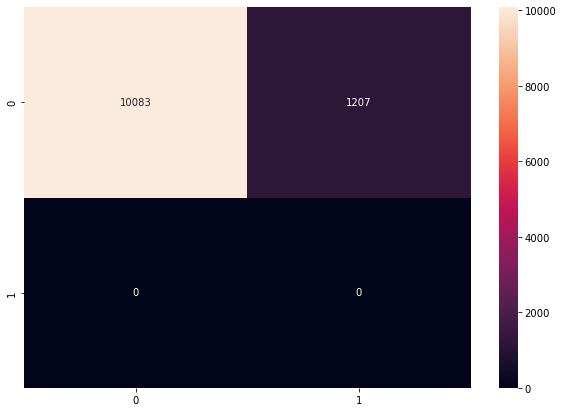

In [223]:
# Baseline model -- would just predict 3 everytime
constant_pred = np.repeat(0, test.shape[0])
base_acc = accuracy_score(constant_pred, test_Y)
# base_roc_auc = roc_auc_score(constant_pred, test_Y)
print("Accuracy from constant prediction model: ", base_acc)
print("Macro-F1 from constant prediction model: ", f1_score(test_Y, constant_pred, average="macro"))

base_conf = confusion_matrix(constant_pred, test_Y)

plt.figure(figsize = (10,7))
sn.heatmap(base_conf, annot=True,  fmt='g')


### ROS

In [224]:
# resampling or other feature engineering techniques
ros = RandomOverSampler()
dev_ROS = ros.fit_resample(dev_X, dev_Y)
dev_ROS_X = dev_ROS[0]
dev_ROS_Y = dev_ROS[1]


### Lets see how a baseline logistic regression model does on our ROS, SMOTE and class-weighting

Index(['ZIPCODE', 'CUISINE DESCRIPTION', 'ClosestWorkingTankDis',
       'ClosestBadTankDis', 'BORO_Bronx', 'BORO_Brooklyn', 'BORO_Manhattan',
       'BORO_Queens', 'BORO_Staten Island', 'RESULT'],
      dtype='object')
Index(['ZIPCODE', 'CUISINE DESCRIPTION', 'ClosestWorkingTankDis',
       'ClosestBadTankDis', 'BORO_Bronx', 'BORO_Brooklyn', 'BORO_Manhattan',
       'BORO_Queens', 'BORO_Staten Island', 'RESULT'],
      dtype='object')
Log. Reg F1 score (SMOTE) 0.503844545150791


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


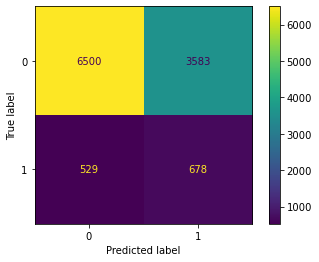

In [225]:
# validation
print(dev_ROS_X.columns)
print(test_X.columns)
lr_SMOTE = LogisticRegression()
lr_SMOTE.fit(dev_ROS_X, dev_ROS_Y)
lr_SMOTE_preds = lr_SMOTE.predict(test_X)
plot_confusion_matrix(lr_SMOTE, test_X, test_Y)
# print("Log. Reg ROC AUC score (SMOTE)", myscore(lr_SMOTE, test_X, test_Y))
print("Log. Reg F1 score (SMOTE)", f1_score(test_Y, lr_SMOTE_preds, average="macro"))

In [ ]:
# visualization